**Prediction of the next word by the preceeding 16 words**    

This preprocessing is based on Dict 2.5 (Keiko updated).



In [ ]:
ver = 21246;

In [ ]:
ver

21246

In [ ]:
from os.path import exists
if not exists('./master_data/'): ## for google colab
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd "gdrive/My Drive/Colab/NLP"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab/NLP


In [ ]:
NLTK = 0;  WIKI = 1;  NLTK_WIKI = 2;
corpus = NLTK;

In [ ]:
import numpy as np
np.set_printoptions(threshold=np.inf)

In [ ]:
import joblib

In [ ]:
if exists('./master_data/glove-wiki-gigaword-100.pkl'):
    wv = joblib.load('./master_data/glove-wiki-gigaword-100.pkl')
else:
    !pip install gensim
    import gensim.downloader as api
    wv = api.load('glove-wiki-gigaword-100') ### 'glove-twitter-25', 'word2vec-google-news-300', 'word2vec-ruscorpora-300'
    joblib.dump(wv, './master_data/glove-wiki-gigaword-100.pkl', compress=3);   # ========== save in npz file ============

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf_ver = tf.__version__
print(tf_ver)

2.11.0


In [ ]:
pre_epoch = 0;   pretrained = 0;
####### loading pretrained sents ##############
if exists('./saved_model/np_'+'{0:03d}'.format(ver)+'_1.pkl'):
    w_idx, idx_to_word, sents_0, loss_his, inc_tmstep_valrate, w2v_out = joblib.load('./saved_model/np_'+'{0:03d}'.format(ver)+'_1.pkl');  pretrained=1;
elif exists('./saved_model/np_'+'{0:03d}'.format(ver)+'_0.pkl'):
    w_idx, idx_to_word, sents_0, loss_his, inc_tmstep_valrate, w2v_out = joblib.load('./saved_model/np_'+'{0:03d}'.format(ver)+'_0.pkl');  pretrained=1;
####### loading corpus ##############
elif corpus == NLTK:
    w_idx, idx_to_word, sents_0= joblib.load('./master_data/sents_nltk.pkl');
elif corpus == WIKI:
    w_idx, idx_to_word, sents_0= joblib.load('./master_data/sents_wiki_32.pkl')
    # w_idx, idx_to_word, sents_0= joblib.load('./master_data/sents_wiki_64.pkl')
    # # w_idx, idx_to_word, sents_0= joblib.load('./NLP/master_data/sents_wiki_15.pkl')
elif corpus == NLTK_WIKI:
    w_idx, idx_to_word, sents__1= joblib.load('./master_data/sents_nltk.pkl');
    w_idx, idx_to_word, sents__2= joblib.load('./master_data/sents_wiki_32.pkl')
    sents_0 = np.concatenate((sents__1, sents__2), axis=0);

In [ ]:
if pretrained ==0:   sents_0 = np.random.permutation(sents_0); ##### shuffling sentenses #####
sents = sents_0 + 0;     sent_2 = sents +0;
if pretrained ==1:
    if len(inc_tmstep_valrate)>23:  pre_epoch = inc_tmstep_valrate[23];

In [ ]:
### loading tokenizer from Dict 02.5 ####
if tf_ver[:4] == '2.11':
    with open('./master_data/tokenizer_master_211.pkl', 'rb') as handle:    tokenizer = joblib.load(handle);
elif tf_ver[:4] == '2.9.':
    with open('./master_data/tokenizer_master_209.pkl', 'rb') as handle:    tokenizer = joblib.load(handle);
else:
    with open('./master_data/tokenizer_master.pkl', 'rb') as handle:        tokenizer = joblib.load(handle);

In [ ]:
##### preprocessing: tokenizing #####
w_idx = tokenizer.word_index
w_idx['_'] = 0;   w_idx['unk'] = 1;
idx_to_word = dict([(value, key) for (key, value) in w_idx.items()])

In [ ]:
print(w_idx)

{'unk': 1, 'the': 2, 'and': 3, 'of': 4, 'to': 5, 'a': 6, 'in': 7, 'was': 8, 'i': 9, 'he': 10, 'it': 11, 'that': 12, 'not': 13, 'his': 14, 'for': 15, 'you': 16, 'is': 17, 'as': 18, 'her': 19, 'with': 20, 'had': 21, 'be': 22, 'she': 23, 'but': 24, 'at': 25, 'on': 26, 'have': 27, 'dr': 28, 'all': 29, 'this': 30, 'him': 31, 'by': 32, 'they': 33, 'from': 34, 'so': 35, 'would': 36, 'were': 37, 'one': 38, 'which': 39, 'no': 40, 'will': 41, 'there': 42, 'are': 43, 'or': 44, 'my': 45, 'could': 46, 'do': 47, 'an': 48, 'what': 49, 'been': 50, 'when': 51, 'zero': 52, 'me': 53, 'their': 54, 'them': 55, 'very': 56, 'if': 57, 'more': 58, 'out': 59, 'who': 60, 'up': 61, 'said': 62, 'we': 63, 'now': 64, 'can': 65, 'little': 66, 'did': 67, 'your': 68, 'than': 69, 'then': 70, 'any': 71, 'some': 72, 'into': 73, 'time': 74, 'about': 75, 'only': 76, 'like': 77, 'has': 78, 'man': 79, 'such': 80, 'must': 81, 'much': 82, 'well': 83, 'other': 84, 'smith': 85, 'good': 86, 'how': 87, 'before': 88, 'know': 89, 'ja

In [ ]:
len(w_idx)

3001

In [ ]:
np.size(wv['the'])

100

In [ ]:
################ Word embedding for output dimensions #################
wv_dim = np.size(wv['the']);
null_word = np.zeros(wv_dim);    w2v_mat = np.zeros((len(w_idx), wv_dim));
for id, word in idx_to_word.items():
    try:
        w2v_mat[id] = wv[word]
    except:
        w2v_mat[id] = null_word
w2v_mat[0] = null_word

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=np.size(w2v_mat,1))
pca.fit(w2v_mat[2:,:])
w2v_pca = pca.transform(w2v_mat)
####################################################################

In [ ]:
np.shape(sents)

(79442, 32)

In [ ]:
##### time steps of the preceeding words #####
time_step = np.size(sents,1)//2;             seq_length = 2 * time_step;

In [ ]:
##### preparing training dataset #####
batch_size = 128;
val_batch_size = batch_size;

In [ ]:
##### training data and validation data #######
train_val_rate = 0.90; # 90% for training, 10% for validation
train_start = 0;                train_end = round(len(sents) * train_val_rate)
val_start = train_end + 1;      val_end = len(sents);

In [ ]:
outdim = 16;
w2v_out = w2v_pca[:,:outdim];     w2v_out = np.float32(w2v_out);
w2v_out[0,:] = 0.4;  w2v_out[1,:] = 0.5;

In [ ]:
###################### Buliding ANN Model #####################################################

In [ ]:
dp_rate = 0.0; dp_through_rate = 0.0;
gr_scale = 1;   min_fb_gr_b = - 0.5;  max_fb_gr_b = 0.0;
p_cell = 192;
leaky_relu = 0.02;      sqrt_leak = 1; # (0 or 1) sqrt_leak should be 1, if gr_scale > 1
p_relu_on = 0; p_relu = 0.0;

In [ ]:
if leaky_relu > 0 and sqrt_leak == 1:         leaky_relu_in = np.sqrt(leaky_relu);    leaky_relu_pc = np.sqrt(leaky_relu);
elif leaky_relu > 0:                          leaky_relu_in = 1.0;                    leaky_relu_pc = leaky_relu;
elif leaky_relu == 0 and p_relu_on == 1:      leaky_relu_in = 1.0;                    leaky_relu_pc = 0.0; # dummy (p-relu for pc),
else:                                         leaky_relu_in = 0.0;                    leaky_relu_pc = 0.0; # ReLU in PC and input cells,  ## when leaky_relu == 0 and p_relu_on == 0:
leaky_relu_out = 1.0;

In [ ]:
ind_pos = max_fb_gr_b // ((max_fb_gr_b-min_fb_gr_b) /gr_scale);
cANN_DM = 0;

In [ ]:
shrink_r_out = 1;

In [ ]:
class custom_RNNCell(keras.layers.AbstractRNNCell):
    def __init__(self, units,  **kwargs):
        super(custom_RNNCell, self).__init__(**kwargs)
        self.units = units
        self.prelu = tf.keras.layers.PReLU(alpha_initializer=tf.initializers.constant(p_relu))

    @property
    def state_size(self):
        return self.units

    def build(self, input_shape):
        self.w_ff = self.add_weight( shape=(input_shape[-1], self.units),
            initializer='he_normal',     name='kernel') # glorot_uniform, he_normal, orthogonal,
        self.w_pc2out = self.add_weight( shape=(self.units, self.units//shrink_r_out),
            initializer='identity', trainable=True,    name='recurrent_w0')
        self.w_pc2out = tf.concat([tf.eye(self.units//shrink_r_out) for i in range(shrink_r_out)],0) # producing multiple copies of states in input layer
        self.w_out2in = self.add_weight( shape=(self.units//shrink_r_out, self.units//shrink_r_out * gr_scale),
            initializer='identity', trainable=True,    name='recurrent_w1')
        self.w_out2in = tf.concat([tf.eye(self.units//shrink_r_out) for i in range(gr_scale)],1) # producing multiple copies of states in input layer
        self.b_r_in = self.add_weight( shape=(self.units//shrink_r_out * gr_scale,),
            name='recurrent_bias',  trainable=True,    initializer='zeros')   # for recurrent input cells
        self.w_in2pc = self.add_weight( shape=(self.units//shrink_r_out * gr_scale, self.units),
            initializer='he_normal',    trainable=True, name='recurrent_w2') #  # recurrent kernel
        self.bias = self.add_weight( shape=(self.units,),
            name='bias',     initializer='zeros')  # 'glorot_normal', 'zeros', 'he_normal'
        self.built = True

    def call(self, inputs, states):
        # === recurrent activity (pc -> input cells) ======
        act_pc = states[0]
        act_out = tf.matmul(act_pc, self.w_pc2out)
        act_out = tf.nn.leaky_relu(act_out, alpha = leaky_relu_out)
        act_in = tf.matmul(act_out, self.w_out2in)
        act_in = act_in + self.b_r_in
        act_in = tf.nn.leaky_relu(act_in, alpha = leaky_relu_in)
        # ==== PC activity ====
        h = tf.matmul(inputs, self.w_ff);
        h = h + self.bias;
        pc = h + tf.matmul(act_in, self.w_in2pc);
        if leaky_relu == 0 and p_relu_on == 1:          pc = self.prelu(pc)
        else:                                           pc = tf.nn.leaky_relu(pc, alpha = leaky_relu_pc)
        return pc, pc

In [ ]:
n_mod = 10;
lk_relu_ff_out = 0.5;

In [ ]:
##### building the model ######
def seq2vec_model_builder(HIDDEN_DIM,n_mod):
    ##### input and embedding (one-hot) ######
    encoder_inputs = tf.keras.layers.Input(shape=(time_step, ), dtype='int32',)
    encoder_embedding = tf.keras.layers.Embedding(len(w_idx), len(w_idx), embeddings_initializer='identity', mask_zero=True, trainable=False)(encoder_inputs)
    ##### RNN ##########
    c_cell = custom_RNNCell( HIDDEN_DIM )
    c_cell.initial_state = tf.zeros((1, HIDDEN_DIM), tf.float32)
    encoder_RNN = tf.keras.layers.RNN(c_cell, return_state=True,  name='sRNN')
    encoder_outputs, state_h = encoder_RNN(encoder_embedding)
    ##### output (dense) layer ##########
    dense_layer = tf.keras.layers.Dense(outdim, bias_initializer=keras.initializers.RandomNormal(stddev=0.001), activation='linear')
    outputs_0 = dense_layer(encoder_outputs)
    ##### 2nd module ##########
    RNN_1, encoder_outputs_1, state_h_1, dense_layer_1, outputs_1 = [],[],[],[],[]
    for m in range(n_mod-1):
        c_cell = custom_RNNCell( HIDDEN_DIM )
        RNN_t = tf.keras.layers.RNN(c_cell, return_state=True);     # RNN_1.append(RNN_t)
        encoder_outputs_t, state_h_t = RNN_t(encoder_embedding);    encoder_outputs_1.append(encoder_outputs_t); state_h_1.append(state_h_t);
        # dense_layer_t = layers.Dense(outdim, bias_initializer=keras.initializers.RandomNormal(stddev=0.001), activation='linear'); # dense_layer_1.append(dense_layer_t);
        dense_layer_t = tf.keras.layers.Dense(outdim, kernel_initializer=keras.initializers.RandomUniform(minval=-0.3, maxval=0.3), bias_initializer=keras.initializers.TruncatedNormal(stddev=0.001), activation=tf.keras.layers.LeakyReLU(alpha=lk_relu_ff_out));
        outputs_t = dense_layer_t(encoder_outputs_t); outputs_1.append(outputs_t);
    outputs = tf.concat([outputs_0] + outputs_1,axis=1)

    model = keras.Model(encoder_inputs, outputs)
    return model
model = seq2vec_model_builder(HIDDEN_DIM = p_cell, n_mod=n_mod)

In [ ]:
np.sqrt(6/(192+32)) # # init = 'glorot_uniform'

0.16366341767699427

In [ ]:
inter_output_model = keras.Model(model.input, model.get_layer('sRNN').output )

In [ ]:
model.get_layer('sRNN')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 16, 3001)     9006001     ['input_1[0][0]']                
                                                                                                  
 sRNN (RNN)                     [(None, 192),        613440      ['embedding[0][0]']              
                                 (None, 192)]                                                     
                                                                                                  
 rnn (RNN)                      [(None, 192),        613440      ['embedding[0][0]']          

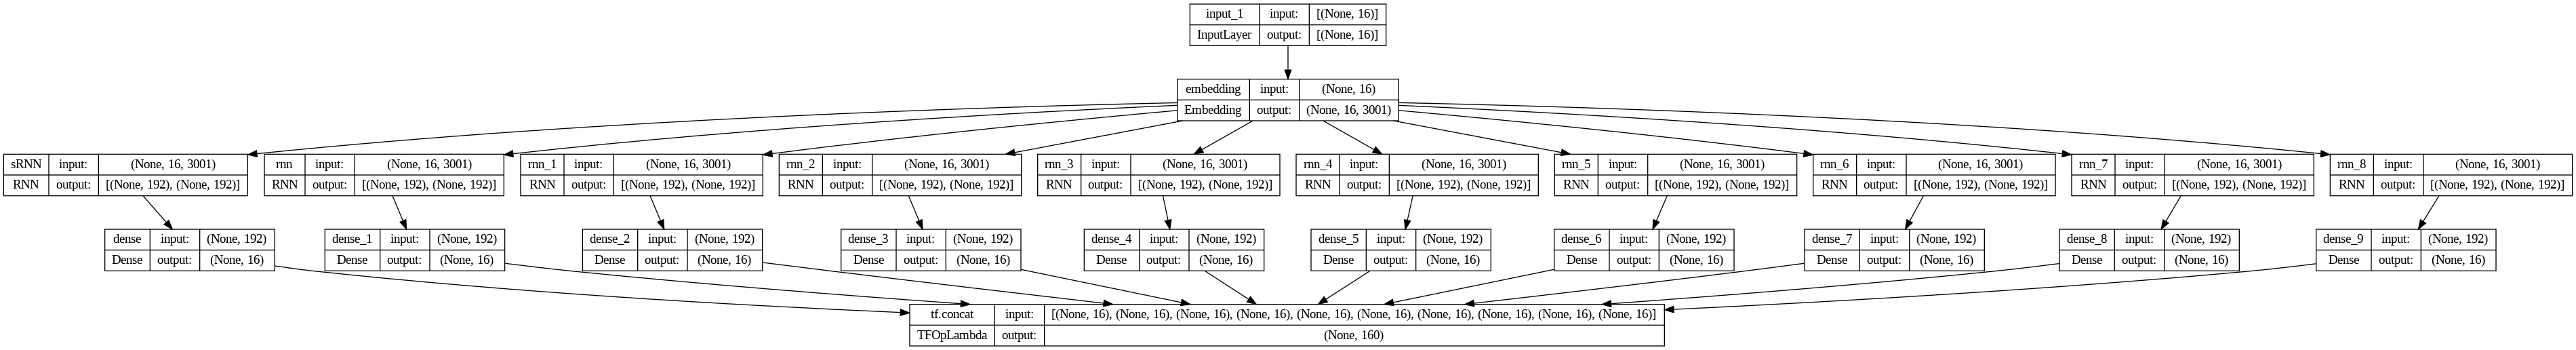

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
def sample_generator(start, end):
    # while True:
    for ep in range(10000):
        start0 = start + (ep%2)*(batch_size//2);  end0 = end - batch_size + (ep%2)*(batch_size//2);
        if ep%2 == 0 and start<train_end:     sent_2[train_start:train_end,:] = np.random.permutation(sent_2[train_start:train_end,:])
        elif ep> 0 and start>train_end:       sent_2[val_start:val_end,:] = np.random.permutation(sent_2[val_start:val_end,:])
        for step in range((end0 - start0) // batch_size):
            x, y = [],[]
            for line in range(batch_size):
                dataset = tf.keras.preprocessing.sequence.TimeseriesGenerator(
                    sent_2[start0+step*batch_size+line],
                    sent_2[start0+step*batch_size+line],  length=time_step,   batch_size=1)
                for batch in dataset:
                    X, Y = batch;      x.extend(X[0]);     y.extend(Y);
            x = np.reshape(x,((seq_length-time_step)*batch_size,time_step))
            y_0 = np.matmul(keras.utils.to_categorical(y, len(w_idx)), w2v_out)  # target in the embedding space
            y = np.tile(y_0,(1,n_mod));
            yield x, y

In [ ]:
def sample_generator_evaluation(start, end):
    for step in range((end - start) // val_batch_size):
        x, y = [],[]
        for line in range(val_batch_size):
            dataset = tf.keras.preprocessing.sequence.TimeseriesGenerator(
                sents[start+step*val_batch_size+line],   sents[start+step*val_batch_size+line],  length=time_step,   batch_size=1)
            for batch in dataset:     X, Y = batch;   x.extend(X[0]);   y.extend(Y);
        x = np.reshape(x,((seq_length-time_step)*val_batch_size,time_step))
        y_0 = np.matmul(keras.utils.to_categorical(y, len(w_idx)), w2v_out)  # target in the embedding space
        y = np.tile(y_0,(1,n_mod));
        yield x, y

In [ ]:
increments = 32   ## split epoch (Equivalent to learning the whole sentence once) into XX

In [ ]:
rand_mod_0 = 0.16;
second_mod_0 = rand_mod_0;

In [ ]:
rand_mod = tf.Variable(rand_mod_0, trainable=False)

In [ ]:
def my_loss(y_true, y_pred):
    num_rows = y_true.get_shape().as_list()
    tile2 = tf.constant([num_rows[0],1,1], tf.int32);   w2v_tiled = tf.tile(tf.reshape(tf.cast( w2v_out[:2,:],dtype=tf.float32),[1,2,outdim]),tile2);   # batch x 2(3001) x outdim(32)
    tile1 = tf.constant([1,2,1], tf.int32);    y_true_tiled = tf.tile(tf.reshape(y_true[:,:outdim],[-1,1,outdim]),tile1);     # batch x 2(3001) x outdim(32)
    err_y_true = tf.reduce_sum( tf.math.abs( y_true_tiled - w2v_tiled), axis=2);                                              # batch x 2(3001)
    y_true_0_1 = tf.math.logical_not( tf.math.reduce_any(tf.math.less(err_y_true, 0.001), axis=1, keepdims=True) );           # batch x 1
    mask = tf.cast(y_true_0_1, tf.float32) * 14.0;                                                            # removing y_true = 0 or 'unk'
    ###### masking for mosaic modules like [0 0 0 0 ... 1 1 1 1 ... 0 0 0 0 ...] ######
    diff_3 = tf.reshape(y_true - y_pred, [-1,n_mod,outdim]);                                # batch x n_mod(3) x outdim(32)
    mse_2d = tf.reduce_mean( tf.math.square(diff_3), axis=2);                               # batch x n_mod(3)
    values, indices = tf.math.top_k(-mse_2d, k=2);                                          # batch x 2
    mosaic_best_mod = tf.reshape( tf.cast(tf.math.equal(mse_2d, tf.tile(-values[:,0:1],[1,n_mod]) ), dtype=tf.float32),  [-1,n_mod,1]);  # batch x n_mod(3) x 1
    mosaic_2nd_mod = tf.reshape( tf.cast(tf.math.equal(mse_2d, tf.tile(-values[:,1:],[1,n_mod]) ), dtype=tf.float32),  [-1,n_mod,1]);    # batch x n_mod(3) x 1
    mosaic_rand_mod = tf.reshape( tf.one_hot(tf.random.uniform(shape=[num_rows[0]],maxval=n_mod, dtype=tf.int32), depth=n_mod),  [-1,n_mod,1]);
    # mosaic_mod = tf.cond(tf.random.uniform([1])>rand_mod, lambda: mosaic_best_mod,  lambda: mosaic_rand_mod )
    rand_for_each =  tf.random.uniform([num_rows[0],1,1]); # different learning storategies for diff data points
    mask_best = tf.tile(tf.cast(rand_for_each>rand_mod*(second_mod_0/rand_mod_0+1), dtype=tf.float32),[1,n_mod,1]);  # batch x n_mod(3) x 1
    mask_2nd = tf.tile(tf.cast(tf.logical_and(rand_for_each<rand_mod*(second_mod_0/rand_mod_0+1),rand_for_each>rand_mod), dtype=tf.float32),[1,n_mod,1]);
    mosaic_mod = mosaic_best_mod * mask_best + mosaic_2nd_mod * mask_2nd + mosaic_rand_mod * (1-mask_best-mask_2nd);
    mosaic_mask = tf.reshape( tf.tile(mosaic_mod, tf.constant([1,1,outdim], tf.int32)),  [-1,outdim*n_mod]);         # batch x outdim*n_mod(3)
    mloss = tf.keras.losses.MeanSquaredError();   # MeanAbsoluteError,  MeanSquaredError, KLDivergence
    return mloss(y_true= y_true*mosaic_mask * mask, y_pred= y_pred*(mosaic_mask) * mask )

In [ ]:
def warmup(epoch):
    value = rand_mod_0 * 0.5**(epoch/increments)
    if epoch%increments == 0:
        print("rand_mod:", value)
        tf.keras.backend.set_value(rand_mod, value)

from keras.callbacks import LambdaCallback
wu_cb = LambdaCallback(on_epoch_end=lambda epoch, log: warmup(epoch))

In [ ]:
def top_k_wrapper(m):
    def top_k_mod(y_true, y_pred):
        num_rows = y_true.get_shape().as_list()
        tile2 = tf.constant([num_rows[0],1,1], tf.int32);   w2v_tiled = tf.tile(tf.reshape(tf.cast( w2v_out[:2,:],dtype=tf.float32),[1,2,outdim]),tile2);   # batch x 2(3001) x outdim(32)
        tile1 = tf.constant([1,2,1], tf.int32);    y_true_tiled = tf.tile(tf.reshape(y_true[:,:outdim],[-1,1,outdim]),tile1);     # batch x 2(3001) x outdim(32)
        err_y_true = tf.reduce_sum( tf.math.abs( y_true_tiled - w2v_tiled), axis=2);                                              # batch x 2(3001)
        y_true_0_1 = tf.math.logical_not( tf.math.reduce_any(tf.math.less(err_y_true, 0.001), axis=1) );                          # batch x 0
        y_true = tf.boolean_mask(y_true,y_true_0_1,axis=0);    y_pred = tf.boolean_mask(y_pred,y_true_0_1,axis=0);                # removing y_true = 0 or 'unk'
        ################################################################
        num_rows = y_true.get_shape().as_list()
        tile2 = tf.constant([num_rows[0],1,1], tf.int32);   w2v_t = tf.reshape(tf.cast( w2v_out,dtype=tf.float32),[1,len(w_idx),outdim]);   # tile to batch x 3001 x outdim(32)
        tile1 = tf.constant([1,len(w_idx),1], tf.int32);        y_pred_t = tf.reshape(y_pred,[-1,1,n_mod,outdim]);           # tile to batch x 3001 x n_mod(3) x outdim(32)
        err_y_pred = tf.reduce_mean( tf.math.square( tf.tile(y_pred_t[:,:,m,:],tile1) - tf.tile(w2v_t,tile2)), axis=2)       # batch x 3001
        y_pred_wd = tf.math.argmin(err_y_pred, axis=1, output_type=tf.int32);                                                # batch x 0
        y_true_t = tf.reshape(y_true[:,:outdim],[-1,1,outdim]);                                                              # tile to batch x 3001 x outdim(32)
        err_y_true = tf.reduce_mean( tf.math.square( tf.tile(y_true_t,tile1)  - tf.tile(w2v_t,tf.constant([num_rows[0],1,1], tf.int32))), axis=2);    # batch x 3001
        y_true_wd = tf.math.argmin(err_y_true, axis=1, output_type=tf.int32);             # batch x 0
        correct_preds = tf.cast( tf.equal( y_true_wd, y_pred_wd ) , dtype=tf.float32);    # y_pred_wd vs y_true_wd
        return tf.reduce_mean( correct_preds, axis=0)
    top_k_mod.__name__ = 'm_' + str(m)
    return top_k_mod

In [ ]:
my_metrics = [top_k_wrapper(m) for m in range(n_mod)]

In [ ]:
####### loading pretrained model, if it exists ##############
if exists('./saved_model/model_'+'{0:03d}'.format(ver) + '_1/checkpoint/'):
    model.load_weights('./saved_model/model_'+'{0:03d}'.format(ver) + '_1/checkpoint/')
elif exists('./saved_model/model_'+'{0:03d}'.format(ver) + '_0/checkpoint/'):
    model.load_weights('./saved_model/model_'+'{0:03d}'.format(ver) + '_0/checkpoint/')

In [ ]:
#### optimizer ######
learning_rate = 0.0080;
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=8.0) # Adam, Adadelta, RMSprop, Adagrad,
model.compile(loss=my_loss, optimizer=optimizer, run_eagerly=True, metrics=[my_metrics]) # categorical_crossentropy

In [ ]:
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=increments*10, mode='auto')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.88, patience=increments//4, min_lr=0.00002)  # faster reduce

In [ ]:
h1 = model.evaluate(sample_generator_evaluation(train_start, train_start+(train_end - train_start) //increments))

17/17 [==============================] - 21s 991ms/step - loss: 6.6710 - m_0: 2.2341e-04 - m_1: 1.3743e-04 - m_2: 1.3704e-04 - m_3: 1.8058e-04 - m_4: 1.3743e-04 - m_5: 1.3743e-04 - m_6: 1.8150e-04 - m_7: 1.3743e-04 - m_8: 1.3743e-04 - m_9: 1.4097e-04


In [ ]:
h2 = model.evaluate(sample_generator_evaluation(val_start, val_start+(val_end - val_start)//6) ) # //4

10/10 [==============================] - 10s 1s/step - loss: 6.7510 - m_0: 2.3087e-04 - m_1: 7.4738e-05 - m_2: 7.4738e-05 - m_3: 7.4738e-05 - m_4: 7.4738e-05 - m_5: 7.4738e-05 - m_6: 7.4738e-05 - m_7: 7.4738e-05 - m_8: 7.4738e-05 - m_9: 1.4948e-04


In [ ]:
##### training the model #######
history_callback = model.fit(
    sample_generator(train_start, train_end),
    steps_per_epoch=(train_end - train_start) //increments // batch_size,  # if //80, it comes full circle in increments of 80.
    validation_data=sample_generator(val_start, val_end),
    validation_steps=(val_end - val_start) // batch_size //16,  ## //4
    initial_epoch = pre_epoch,
    epochs = pre_epoch + increments*8,
    verbose=1,
    callbacks=[ EarlyStopping, reduce_lr, wu_cb] )

Epoch 1/8


17/17 [==============================] - 42s 2s/step - loss: 13.4934 - m_0: 0.0039 - m_1: 5.3673e-04 - m_2: 0.0036 - m_3: 0.0026 - m_4: 0.0048 - m_5: 0.0222 - m_6: 4.9417e-04 - m_7: 7.6066e-04 - m_8: 1.7721e-04 - m_9: 6.2149e-04 - val_loss: 4.0601 - val_m_0: 0.0235 - val_m_1: 7.5905e-04 - val_m_2: 0.0101 - val_m_3: 0.0081 - val_m_4: 7.5670e-04 - val_m_5: 0.0481 - val_m_6: 0.0023 - val_m_7: 2.5407e-04 - val_m_8: 0.0000e+00 - val_m_9: 2.4857e-04 - lr: 0.0080
Epoch 2/8
17/17 [==============================] - 37s 2s/step - loss: 4.0177 - m_0: 0.0130 - m_1: 0.0021 - m_2: 0.0182 - m_3: 0.0064 - m_4: 0.0014 - m_5: 0.0529 - m_6: 0.0032 - m_7: 1.8244e-04 - m_8: 4.0238e-04 - m_9: 3.5755e-04 - val_loss: 3.9208 - val_m_0: 0.0290 - val_m_1: 0.0032 - val_m_2: 0.0313 - val_m_3: 0.0092 - val_m_4: 0.0020 - val_m_5: 0.0581 - val_m_6: 0.0042 - val_m_7: 4.9191e-04 - val_m_8: 7.4405e-04 - val_m_9: 4.9826e-04 - lr: 0.0080
Epoch 3/8
17/17 [==============================] - 35s 2s/step - loss: 3.8131 - m_0: 

In [ ]:
history_callback.history.keys()

dict_keys(['loss', 'm_0', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'val_loss', 'val_m_0', 'val_m_1', 'val_m_2', 'val_m_3', 'val_m_4', 'val_m_5', 'val_m_6', 'val_m_7', 'val_m_8', 'val_m_9', 'lr'])

In [ ]:
lr = history_callback.history["lr"];    lr = np.array(lr[:1]+lr);

In [ ]:
topk, val_topk = [],[];
topk.append(np.array(history_callback.history["m_0"]));  topk.append(np.array(history_callback.history["m_1"]));  topk.append(np.array(history_callback.history["m_2"]));
topk.append(np.array(history_callback.history["m_3"]));  topk.append(np.array(history_callback.history["m_4"]));
val_topk.append(np.array(history_callback.history["val_m_0"]));  val_topk.append(np.array(history_callback.history["val_m_1"]));  val_topk.append(np.array(history_callback.history["val_m_2"]));
val_topk.append(np.array(history_callback.history["val_m_3"]));  val_topk.append(np.array(history_callback.history["val_m_4"]));
if n_mod>5:
    topk.append(np.array(history_callback.history["m_5"]));  topk.append(np.array(history_callback.history["m_6"]));  topk.append(np.array(history_callback.history["m_7"]));
    topk.append(np.array(history_callback.history["m_8"]));  topk.append(np.array(history_callback.history["m_9"]));
    val_topk.append(np.array(history_callback.history["val_m_5"]));  val_topk.append(np.array(history_callback.history["val_m_6"]));  val_topk.append(np.array(history_callback.history["val_m_7"]));
    val_topk.append(np.array(history_callback.history["val_m_8"]));  val_topk.append(np.array(history_callback.history["val_m_9"]));

In [ ]:
topk = np.stack(topk,axis=1);   topk = np.concatenate(( np.reshape(np.array(h1[1:]),[1,-1]), topk), axis=0)
val_topk = np.stack(val_topk,axis=1);    val_topk = np.concatenate(( np.reshape(np.array(h2[1:]),[1,-1]), val_topk), axis=0)

In [ ]:
np.sum(val_topk,axis=1)

array([0.00097825, 0.09410683, 0.13866931, 0.13932645, 0.1794979 ,
       0.20874913, 0.2020247 , 0.23254276, 0.23158838])

In [ ]:
loss_his = []
loss_his.append( np.array( h1[0:1]+ history_callback.history["loss"] ) )
loss_his.append( np.sum(topk,axis=1) );    # loss_his.append( np.array( h1[2:]+ history_callback.history["my_top_k_acc"] ) )
loss_his.append( np.array( h2[0:1]+ history_callback.history["val_loss"] ) )
loss_his.append( np.sum(val_topk,axis=1) );    # loss_his.append( np.array( h2[2:]+ history_callback.history["val_my_top_k_acc"] ) )

In [ ]:
pre_epoch = pre_epoch + len(loss_his[0])-1

In [ ]:
##### Correct rate of validation in the training period  ######
print(loss_his[3][-4:].tolist())
100*np.mean(loss_his[3][-4:])

[0.2087491318816319, 0.20202469811192714, 0.23254276061197743, 0.23158837587106973]


21.872624161915155

In [ ]:
model.save_weights('./saved_model/model_'+'{0:03d}'.format(ver) + '/checkpoint/')

In [ ]:
import matplotlib.pyplot as plt

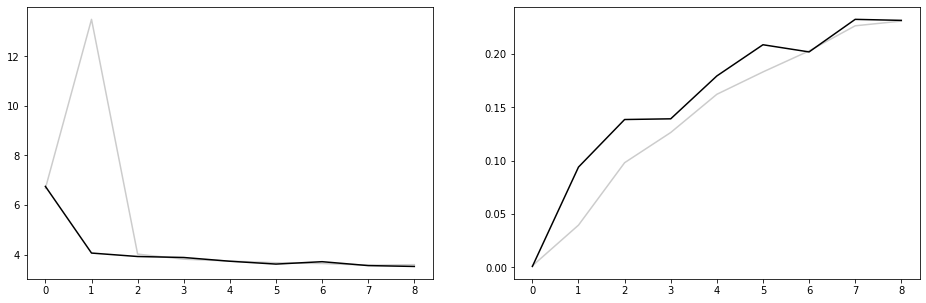

In [ ]:
plt.figure(figsize=(16, 5)) # figure area
plt.subplot(1,2,1)
plt.plot(range(len(loss_his[0])),loss_his[0], color=[0.8, 0.8, 0.8])
plt.plot(range(len(loss_his[2])),loss_his[2], color=[0, 0, 0]);
plt.subplot(1,2,2)
plt.plot(range(len(loss_his[1])),loss_his[1], color=[0.8, 0.8, 0.8])
plt.plot(range(len(loss_his[3])),loss_his[3], color=[0, 0, 0]);

In [ ]:
x, y = [],[]
for line in range(batch_size):
    dataset = tf.keras.preprocessing.sequence.TimeseriesGenerator(
        sents[line],    sents[line],    length=time_step,    batch_size=1)
    for batch in dataset:
        X, Y = batch;        x.extend(X[0]);      y.extend(Y)
x = np.reshape(x,((seq_length-time_step)*batch_size,time_step))
y = keras.utils.to_categorical(y, len(w_idx))

In [ ]:
row_wise_sum  = tf.reduce_sum(tf.gather(y,  [0], axis = 1),axis=1)
valid = tf.where(tf.equal(row_wise_sum,0))
y0 = tf.gather(y,  tf.squeeze(valid), axis = 0);

In [ ]:
x, y = [],[]
for line in range(len(sents)):
    for i in range(len(sents[line])-time_step):
        if np.sum(sents[line][i:i+time_step])==0:  continue
        x.append(sents[line][i:i+time_step])
        y.append(sents[line][i+time_step])

In [ ]:
num_ana = 60

states, vocab = [],[]; n_0 = np.zeros(2);   first_w = np.zeros(num_ana);
for j in range(num_ana):
    k = len(x)-num_ana+j;  w_char = [];
    # k = j+100;  w_char = [];
    x_pred = x[k];   x_pred = np.reshape(x_pred,(1, time_step))
    for i in range(time_step):
        w_char.append(idx_to_word[x[k][i]])
    ##### RNN state prediction and converting it to str ######
    rnn_output, rnn_states = inter_output_model.predict(x_pred)
    states.append(rnn_states)
    vocab.append(idx_to_word[x_pred[0,-1]])
    ##### model prediction and converting it to str ######
    prediction = model.predict(x_pred, verbose=0);    lg = prediction.shape;
    y_pred_0_tiled = np.tile(np.reshape(prediction,[-1,1,n_mod,outdim]), [1,len(w_idx),1,1]);    # batch x 3001 x n_mod(3) x outdim(32)
    w2v_tiled = np.tile(np.reshape(w2v_out,[1,len(w_idx),1,outdim]), [lg[0],1,n_mod,1]);
    err_y_pred_0 = np.mean( np.square( y_pred_0_tiled - w2v_tiled), axis=3);                 # batch x 3001 x n_mod(3)
    index = np.argmin(err_y_pred_0,axis=1);                                                  # batch x n_mod(3)
    result = ''
    for m in range(np.size(index)):
        result = result + idx_to_word[index[:,m].item()] + ' '
    #### first word detection #####
    n_0[0] = n_0[1];     n_0[1] = np.sum(x_pred == 0);
    if n_0[0] < n_0[1]:
        first_w[j] = 1;
    #### output ####
    char = ' '.join(w_char)
    print(char)
    print('    answer:'+str(idx_to_word[y[k]]))
    print('    prediction:'+str(result))

1/1 [==============================] - 0s 232ms/step
_ _ _ _ _ _ _ _ to be together was in his opinion to
    answer:be
    prediction:as sure be his another the come meant _ instead 
1/1 [==============================] - 0s 20ms/step
_ _ _ _ _ _ _ to be together was in his opinion to be
    answer:intimate
    prediction:as done but brought once the even meant unfortunately turning 
1/1 [==============================] - 0s 21ms/step
_ _ _ _ _ _ to be together was in his opinion to be intimate
    answer:and
    prediction:as so to once when the even meant besides turning 
1/1 [==============================] - 0s 33ms/step
_ _ _ _ _ to be together was in his opinion to be intimate and
    answer:while
    prediction:as everyone but he when the even meant besides turning 
1/1 [==============================] - 0s 33ms/step
_ _ _ _ to be together was in his opinion to be intimate and while
    answer:his
    prediction:as something be he another the even instead affair instead 
1/1 [=

In [ ]:
s_ori = np.concatenate(states,axis=0);

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(s_ori)
s_pca = pca.transform(s_ori)

In [ ]:
s2_pca = np.NaN*np.zeros((2*len(first_w),2));  ii=0;
for i in range(len(first_w)):
    if first_w[i]==1:
        s2_pca[ii] = np.NaN;      ii = ii +1;
    s2_pca[ii,:] = s_pca[i,:];    ii = ii +1;

In [ ]:
rand_walk = 0.0;

In [ ]:
inc_tmstep_valrate = [increments, time_step, train_val_rate,lr, gr_scale, dp_rate, min_fb_gr_b, p_cell, dp_through_rate, leaky_relu,
                      p_relu_on, p_relu, sqrt_leak, max_fb_gr_b , cANN_DM, outdim, n_mod, rand_walk, corpus, lk_relu_ff_out, tf_ver,
                      rand_mod_0, second_mod_0, pre_epoch, topk, val_topk, shrink_r_out]

In [ ]:
# ========== save in npz file ============
import joblib
dt =  (w_idx, idx_to_word, sents, loss_his, inc_tmstep_valrate, w2v_out)
joblib.dump(dt, './saved_model/np_'+'{0:03d}'.format(ver)+'.pkl', compress=3)

['./saved_model/np_21246.pkl']

In [ ]:
with open('./saved_model/tokenizer_'+'{0:03d}'.format(ver)+'.pkl', 'wb') as handle:
    joblib.dump(tokenizer, handle)